In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from bmis_emg_utils import * 
from scipy.io import loadmat, savemat

from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn import metrics
import matplotlib
from tensorflow.keras.utils import plot_model
import tensorflow_model_optimization as tfmot

In [2]:
specific_subject = 1
abs_path = os.getcwd().strip('code')
path = os.path.join(abs_path, 'test_data')
data_subject_1, label_subject_1 = get_data_subject_specific(specific_subject)
label_subject_1 = label_subject_1.reshape(-1)
print('The total data shape is {} and label is {}'.format(data_subject_1.shape, label_subject_1.shape))

The total data shape is (8, 66614) and label is (66614,)


In [3]:
X_1, y_1 = window_with_overlap(data_subject_1, label_subject_1, sampling_frequency=200, window_time=200, overlap=50)
print('The total Input data shape after windowing is {} and label is {}'.format(data_subject_1.shape, label_subject_1.shape))

The total Input data shape after windowing is (8, 66614) and label is (66614,)


In [4]:
X_train_1, y_train_1, X_test_1, y_test_1 = spilt_data(X_1, y_1, ratio=0.1)
print('Training Set is{} Test Set {}'.format(X_train_1.shape, X_test_1.shape))

Training Set is(2996, 8, 40) Test Set (333, 8, 40)


In [5]:
specific_subject = 2
abs_path = os.getcwd().strip('code')
path = os.path.join(abs_path, 'test_data')
data_subject_2, label_subject_2 = get_data_subject_specific(specific_subject)
label_subject_2 = label_subject_2.reshape(-1)
print('The total data shape is {} and label is {}'.format(data_subject_2.shape, label_subject_2.shape))

The total data shape is (8, 66556) and label is (66556,)


In [6]:
X_2, y_2 = window_with_overlap(data_subject_2, label_subject_2, sampling_frequency=200, window_time=200, overlap=50)
print('The total Input data shape after windowing is {} and label is {}'.format(data_subject_1.shape, label_subject_1.shape))

The total Input data shape after windowing is (8, 66614) and label is (66614,)


In [7]:
on_device_train, on_device_train_y, on_device_test, on_device_test_y = spilt_data(X_2, y_2, ratio=0.8)
print('Training Set is{} Test Set {}'.format(on_device_train.shape, on_device_test.shape))

Training Set is(665, 8, 40) Test Set (2661, 8, 40)


In [8]:
gesture_list = ['Large Diameter grasp', 'Meduim Ring Diameter Grasp',
               'Three Finger Sphere Grasp', 'Prismatic Pinch Grasp',
               'Power Grasp', 'Cut', 'Rest']

In [9]:
def get_features(data, fs=200, n_samples=40):
    
    f, t, cstft = stft(data, fs, nperseg=n_samples)
    return np.abs(cstft)

In [10]:
cstft_tr_1 = []
cstft_ts_1 = []
cstft_tr_2 = []
cstft_ts_2 = []

for i, idx in enumerate(X_train_1):
    a = get_features(X_train_1[i])
    cstft_tr_1.append(a)


for i, idx in enumerate(X_test_1):
    b = get_features(X_test_1[i])
    cstft_ts_1.append(b)


for i, idx in enumerate(on_device_train):
    c = get_features(on_device_train[i])
    cstft_tr_2.append(c)

for i, idx in enumerate(on_device_test):
    c = get_features(on_device_test[i])
    cstft_ts_2.append(c)
    
cstft_x_train_1 = np.array(cstft_tr_1)
cstft_x_test_1 = np.array(cstft_ts_1)
cstft_on_device_train = np.array(cstft_tr_2)
cstft_on_device_test = np.array(cstft_ts_2)

In [11]:
print("Shape are {},{}".format(cstft_x_train_1.shape, cstft_x_test_1.shape))

Shape are (2996, 8, 21, 3),(333, 8, 21, 3)


In [12]:
print("Shape are {},{}".format(y_train_1.shape, y_test_1.shape))

Shape are (2996, 1),(333, 1)


In [13]:
input_size = cstft_x_train_1.shape[1:]

In [14]:
X_train_cstft = tf.convert_to_tensor(cstft_x_train_1, dtype=tf.float32)
X_test_cstft = tf.convert_to_tensor(cstft_x_test_1, dtype=tf.float32)
#cstft_on_device_train = tf.convert_to_tensor(cstft_on_device_train, dtype=tf.float32)
#cstft_on_device_test = tf.convert_to_tensor(cstft_on_device_test, dtype=tf.float32)

2022-07-31 00:51:00.621151: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-31 00:51:00.621355: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-31 00:51:00.622140: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
path = "/home/darcula-venom/Documents/AI Workspace/Coral_TPU_sEMG_Classifiacation/on_device_test_data"
mdic = {'data': cstft_on_device_train, 'label': on_device_train_y}
savemat(path + "/stft_train_data.mat", mdic)
#save_hardware_test_data(path=path, data=cstft_on_device_train, label=on_device_train_y, choice='Train')
mdic_2 = {'data': cstft_on_device_test, 'label': on_device_test_y}
savemat(path + "/stft_test_data.mat", mdic_2)
#save_hardware_test_data(path=path, data=cstft_on_device_test, label=on_device_test_y, choice='Test')

Convert to TFLIte

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=input_size))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(151, activation='relu'))
model.add(tf.keras.layers.Dense(7, activation='softmax'))

In [17]:
#emg_model = emg_net()
quantized_model = tfmot.quantization.keras.quantize_model(model)
quantized_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 8, 21, 3)          3         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 6, 19, 32)         963       
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 4, 17, 32)         9315      
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 2, 8, 32)          1         
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 2, 8, 32)          1         
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 512)               1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 151)               7

In [18]:
lr = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-07, clipnorm=1)
ls = 'sparse_categorical_crossentropy'
mtr = 'accuracy'
n_batches = 15
n_epochs = 30
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
quantized_model.compile(optimizer=opt, loss=ls, metrics=mtr)

In [19]:
history = quantized_model.fit(X_train_cstft, y_train_1, validation_data=(X_test_cstft,y_test_1), 
                 callbacks=callback, batch_size=n_batches, epochs= n_epochs)

2022-07-31 00:51:02.559391: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-31 00:51:02.578984: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3399905000 Hz


Epoch 1/30
200/200 [==============================] - 5s 19ms/step - loss: 1.7675 - accuracy: 0.2439 - val_loss: 0.6279 - val_accuracy: 0.7598
Epoch 2/30
200/200 [==============================] - 3s 13ms/step - loss: 0.6654 - accuracy: 0.7425 - val_loss: 0.3954 - val_accuracy: 0.8619
Epoch 3/30
200/200 [==============================] - 3s 15ms/step - loss: 0.4561 - accuracy: 0.8346 - val_loss: 0.3808 - val_accuracy: 0.8559
Epoch 4/30
200/200 [==============================] - 3s 16ms/step - loss: 0.3703 - accuracy: 0.8709 - val_loss: 0.3180 - val_accuracy: 0.8709
Epoch 5/30
200/200 [==============================] - 5s 23ms/step - loss: 0.3319 - accuracy: 0.8668 - val_loss: 0.2703 - val_accuracy: 0.8949
Epoch 6/30
200/200 [==============================] - 5s 25ms/step - loss: 0.2885 - accuracy: 0.8953 - val_loss: 0.2616 - val_accuracy: 0.9099
Epoch 7/30
200/200 [==============================] - 5s 23ms/step - loss: 0.2765 - accuracy: 0.9040 - val_loss: 0.2206 - val_accuracy: 0.9279

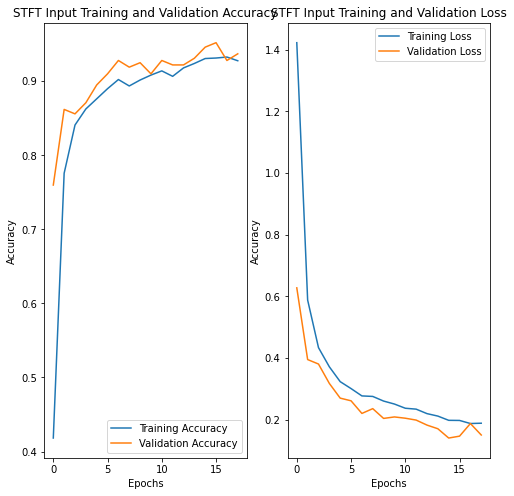

In [21]:
n_epochs = 18
validation_loss = history.history['val_loss']
training_loss = history.history['loss']

validation_accuracy = history.history['val_accuracy']
training_accuracy = history.history['accuracy']

epoch_range = range(n_epochs)
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, training_accuracy, label = "Training Accuracy")
plt.plot(epoch_range, validation_accuracy, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("STFT Input Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epoch_range, training_loss, label = "Training Loss")
plt.plot(epoch_range, validation_loss, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.title("STFT Input Training and Validation Loss")
plt.show()

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
qat_tf_model_quantized_tflite_model = converter.convert()

with open("qat_tf_model_quantized_tflite_model_STFT.tflite", "wb") as f:
    f.write(qat_tf_model_quantized_tflite_model)

2022-07-31 00:52:40.917429: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpmcq_ygk2/assets


INFO:tensorflow:Assets written to: /tmp/tmpmcq_ygk2/assets
2022-07-31 00:52:42.077167: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-07-31 00:52:42.077294: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-07-31 00:52:42.078709: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.002ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2022-07-31 00:52:42.138249: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-07-31 00:52:42.138281: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.
2022-07-31 00:52:42.142712: I tensorflow/core/common_runtime/process_util.cc:146] Creat

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
qat_tflite_model = converter.convert()

with open('QAT_BMIS_EMG_NET_STFT_INPUT.tflite', 'wb') as f:
  f.write(qat_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpt1ybqmv0/assets


INFO:tensorflow:Assets written to: /tmp/tmpt1ybqmv0/assets
2022-07-31 00:52:44.009256: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-07-31 00:52:44.009361: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-07-31 00:52:44.010687: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.002ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2022-07-31 00:52:44.070066: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2022-07-31 00:52:44.070099: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


In [24]:
def set_input_tensor(interpreter, input):
    
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('QAT_BMIS_EMG_NET_STFT_INPUT.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(y_test_1, axis=1)

for i in range(len(X_test_cstft)):
  prediction = classify_image(interpreter, X_test_cstft[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Quant TF Lite accuracy: 100.000%


In [25]:
pred = quantized_model.predict(X_test_cstft)
y_pred = np.argmax(pred, axis=-1)
accuracy_score(y_test_1, y_pred)

0.9369369369369369

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

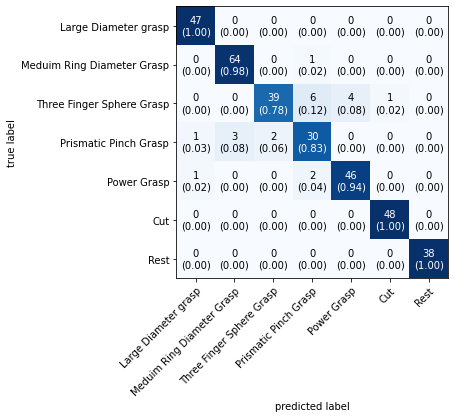

In [26]:
confusion = confusion_matrix(y_test_1, y_pred)
plot_confusion_matrix(conf_mat=confusion, figsize=(5,5), class_names=gesture_list, show_normed=True)

In [27]:
dataset = loadmat('/home/darcula-venom/Documents/AI Workspace/Coral_TPU_sEMG_Classifiacation/on_device_test_data/stft_test_data.mat')
d = dataset['data']
l = dataset['label']

In [28]:
d.shape

(2661, 8, 21, 3)